In [ ]:
# https://nthu-datalab.github.io/ml/labs/14-2_GAN/14-2_GAN.html

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 1000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

IW_EPOCH = 256

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 0x2400)])

In [3]:
!nvidia-smi

Tue Dec 21 15:30:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8    10W / 250W |     16MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [45]:
data_dir = 'img_align_celeba_png/'
img_names = os.listdir(data_dir)
# choose num_sample let num_sample % BATCH_SIZE == 0
print(len(img_names))
num_samples = 200000
x_train = [data_dir + img_name for img_name in img_names[:num_samples]]
# print(len(x_train))

202599


In [59]:
def load_and_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=IMG_C)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255.0)

    return img

In [60]:
img_names_dataset = tf.data.Dataset.from_tensor_slices(x_train)
dsTrain = img_names_dataset.map(load_and_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dsTrain = dsTrain.shuffle(BUF).batch(BATCH_SIZE, True)

In [61]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out


In [62]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [63]:
IW_G, IW_D = GAN(IMG_SHAPE, Z_DIM)
IW_LR = 2.0e-04
beta_1 = 0.0
beta_2 = 0.9
LAMBDA = 10

optimizer_g = keras.optimizers.Adam(IW_LR, beta_1, beta_2)
optimizer_d = keras.optimizers.Adam(IW_LR, beta_1, beta_2)

@tf.function
def IW_D_Train(c1, epsilon):
    z = tf.random.normal(BZ)

    with tf.GradientTape(persistent=True) as tpd:
        x_bar = IW_G(z, training = True)
        x = c1
        x_hat = epsilon * x + (1 - epsilon) * x_bar

        Dw_x_bar = IW_D(x_bar, training=True)
        Dw_x = IW_D(x, training=True)
        Dw_x_hat = IW_D(x_hat, training=True)

        Dw_x_hat_grad = tpd.gradient(Dw_x_hat, x_hat)
        L_norm2 = tf.sqrt(tf.reduce_sum(Dw_x_hat_grad**2))
        gradient_penalty = tf.reduce_mean((L_norm2 - 1.0)**2)

        ld = tf.reduce_mean(Dw_x_bar) - tf.reduce_mean(Dw_x) + LAMBDA * gradient_penalty
        lg = - tf.reduce_mean(Dw_x_bar)

    gradient_d = tpd.gradient(ld, IW_D.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, IW_D.trainable_variables))
    
    return lg, ld

@tf.function
def IW_G_Train(c1, epsilon):
    z = tf.random.normal(BZ)

    with tf.GradientTape(persistent=True) as tpg:
        x_bar = IW_G(z, training = True)
        x = c1
        x_hat = epsilon * x + (1 - epsilon) * x_bar

        Dw_x_bar = IW_D(x_bar, training=True)
        Dw_x = IW_D(x, training=True)
        Dw_x_hat = IW_D(x_hat, training=True)

        Dw_x_hat_grad = tpg.gradient(Dw_x_hat, x_hat)
        L_norm2 = tf.sqrt(tf.reduce_sum(Dw_x_hat_grad**2))
        gradient_penalty = tf.reduce_mean((L_norm2 - 1.0)**2)

        ld = tf.reduce_mean(Dw_x_bar) - tf.reduce_mean(Dw_x) + LAMBDA * gradient_penalty
        lg = - tf.reduce_mean(Dw_x_bar)

    gradient_g = tpg.gradient(lg, IW_G.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, IW_G.trainable_variables))
    
    return lg, ld

In [64]:
# ratio of training step D:G = 5:1
IW_Train = (
    IW_D_Train,
    IW_D_Train,
    IW_D_Train,
    IW_D_Train,
    IW_D_Train,
    IW_G_Train
)

IWCritic = len(IW_Train)

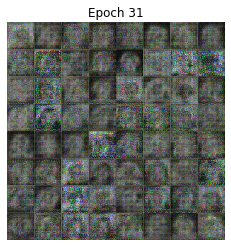

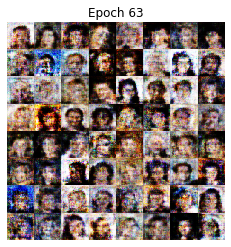

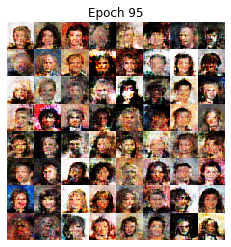

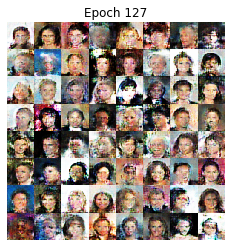

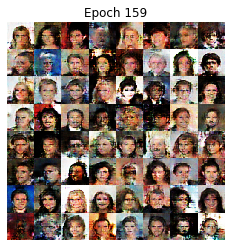

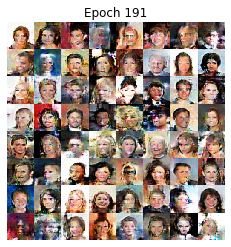

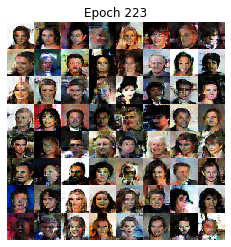

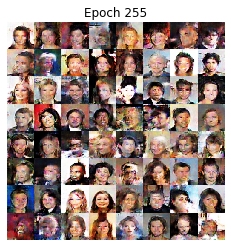

In [65]:
IW_lg = [None] * IW_EPOCH #record loss of g for each epoch
IW_ld = [None] * IW_EPOCH #record loss of d for each epoch
IW_sp = [None] * IW_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(x_train))
ctr = 0
for ep in range(IW_EPOCH):
    loss_g_t = 0.0  
    loss_d_t = 0.0
    for batch in dsTrain:
        epsilon = np.random.uniform(low=0.0, high=1.0)
        epsilon = tf.convert_to_tensor(epsilon, dtype=tf.float32)
        loss_g, loss_d = IW_Train[ctr](batch, epsilon)
        ctr += 1
        loss_g_t += loss_g.numpy()
        loss_d_t += loss_d.numpy()
        if ctr == IWCritic : ctr = 0
    IW_lg[ep] = loss_g_t * rsTrain
    IW_ld[ep] = loss_d_t * rsTrain
    
    out = IW_G(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/%04d.png" % ep
    )
    IW_sp[ep] = img
    if (ep + 1) % 32 == 0:
        plt.imshow(img[..., :])
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [66]:
def utMakeGif(imgs, fname, duration):
  n = float(len(imgs)) / duration
  clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
  clip.write_gif(fname, fps = n)

In [67]:
utMakeGif(np.array(IW_sp), "improved_wgan.gif", duration = 2)

MoviePy - Building file improved_wgan.gif with imageio.


In [68]:
len(np.array(IW_sp))

256

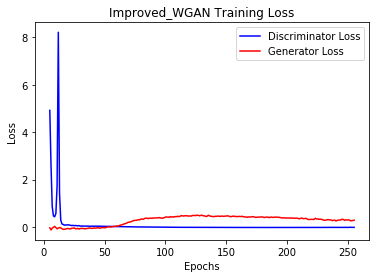

In [69]:
plt.plot(range(5,IW_EPOCH), IW_ld[5:], color = "blue", label = "Discriminator Loss")
plt.plot(range(5,IW_EPOCH), IW_lg[5:], color = "red",  label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Improved_WGAN Training Loss")
plt.show()

# Brief Report

What I had done in this lab,

1. Read input and generate dataset
    - read data from img_align_celeba_png folder
    - preprocessing
    - Due to memory restrict, I can't load all the images into the array in the same time
    - Use tf.data.Dataset to map load_preprocessing function, load data one by one
    - select 200000 num_samples from dataset (according to TA mentioned, num_samples % BATCH_SIZE == 0)

2. Implement Improved WGAN
    - rewrite IW_D_Train, IW_G_Train
    - add epsilon that generate noise from uniform [0,1]
    - add gradient penalty
    
3. Goolge drive link (contain: best_generate_sample.png, loss.png, improved_wgan.gif)
    - https://drive.google.com/drive/folders/1q7dnDrOob1bGT9iGPdRK6VMjsBBPrG5p?usp=sharing